In [401]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from sklearn.preprocessing import StandardScaler 
from sklearn.model_selection import train_test_split, TimeSeriesSplit, RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from scipy.stats import randint



### Read data

In [402]:
# Loda data
target = pd.read_csv('../data/processed/properties.csv')
features = pd.read_csv('../data/processed/features.csv')

# Merge data
df = pd.merge(target, features, on='period')


In [403]:
df.head()

,period,num_nodes,num_edges,density,clustering,assortativity,shortest_path,TPU,GPR,CPTOTSAXN,DXGSRMRCHSACD,DMGSRMRCHSACD,IPTOTSAKD,IMPCOV,NEER,REER,RETSALESSA,TOTRESV,UNEMPSA_
0,2000M01,109,300,0.050968,0.521949,-0.620508,2.078491,32.117348,64.457809,76.089042,484771.067659,784349.502592,9.967223e+11,2.476091,883.756875,104.048961,61.870157,1.942120e+06,8.614909
1,2000M02,122,333,0.045116,0.496115,-0.616266,NaN,28.175856,63.541721,76.318397,496700.992153,943444.352810,1.010232e+12,2.063868,896.988312,104.329262,62.339465,1.947145e+06,8.620393
2,2000M03,118,342,0.049544,0.581137,-0.617675,2.092424,36.838506,50.101986,76.498010,497995.743462,846133.068963,1.014447e+12,2.330691,903.555596,104.515925,62.045241,1.972075e+06,8.500496
3,2000M04,118,339,0.049109,0.611388,-0.631199,2.095755,35.281040,48.682739,76.454511,482444.395690,860083.949923,1.018283e+12,2.299383,910.134906,104.679618,60.628472,1.977663e+06,8.448069
4,2000M05,115,344,0.052479,0.594336,-0.595801,2.056445,49.327563,79.482880,76.617165,506354.667550,894550.760808,1.029954e+12,2.225832,931.339312,105.262834,60.970381,1.991119e+06,8.425447


In [404]:
# Exclude 'Period'
numerical_columns = df.columns.difference(['period'])  # Exclude 'Period'

# Create a StandardScaler
scaler = StandardScaler()  

# Standardize the numerical columns
df[numerical_columns] = scaler.fit_transform(df[numerical_columns])

# Use the interpolate method to fill missing values with interpolation
df = df.interpolate()

# Sort the DataFrame by the 'period' column
df = df.sort_values(by='period')


In [405]:
df.head()

,period,num_nodes,num_edges,density,clustering,assortativity,shortest_path,TPU,GPR,CPTOTSAXN,DXGSRMRCHSACD,DMGSRMRCHSACD,IPTOTSAKD,IMPCOV,NEER,REER,RETSALESSA,TOTRESV,UNEMPSA_
0,2000M01,-1.948394,-1.448399,-1.414807,-2.186714,-1.259805,-1.004870,-0.368810,-0.781599,-1.455154,-1.710588,-1.819401,-1.581324,-1.522194,2.143476,1.117513,-2.063499,-1.676405,1.318717
1,2000M02,-1.527840,-1.407005,-1.627368,-2.563903,-1.201577,-0.804972,-0.460799,-0.799224,-1.444573,-1.680488,-1.586099,-1.529528,-1.900767,2.187024,1.249075,-2.031613,-1.675187,1.325436
2,2000M03,-1.657241,-1.395715,-1.466552,-1.322546,-1.220917,-0.605075,-0.258625,-1.057799,-1.436288,-1.677221,-1.728800,-1.513366,-1.655725,2.208639,1.336687,-2.051603,-1.669144,1.178535
3,2000M04,-1.657241,-1.399478,-1.482336,-0.880870,-1.406572,-0.509464,-0.294974,-1.085105,-1.438294,-1.716458,-1.708341,-1.498659,-1.684477,2.230293,1.413517,-2.147863,-1.667789,1.114300
4,2000M05,-1.754292,-1.393207,-1.359942,-1.129837,-0.920644,-1.637492,0.032853,-0.492522,-1.430791,-1.656131,-1.657798,-1.453912,-1.752025,2.300082,1.687255,-2.124633,-1.664528,1.086583


### Uncertainty measurement

In [406]:
import pandas as pd

# Get the actual names of the target columns
target_columns = ['num_nodes', 'num_edges', 'density', 'clustering', 'assortativity', 'shortest_path']

# Copy the original DataFrame to avoid modifying the original data
lag1_df = df.copy()
lag3_df = df.copy()
lag6_df = df.copy()

# Shift target columns by 1, 3, and 6 periods in respective lag DataFrames
for column in target_columns:
    lag1_df[f'{column}'] = lag1_df[column].shift(1)
    lag3_df[f'{column}'] = lag3_df[column].shift(3)
    lag6_df[f'{column}'] = lag6_df[column].shift(6)

# Drop rows with NaN values in lag DataFrames
lag1_df = lag1_df.dropna()
lag3_df = lag3_df.dropna()
lag6_df = lag6_df.dropna()


In [407]:
lag6_df.head()

,period,num_nodes,num_edges,density,clustering,assortativity,shortest_path,TPU,GPR,CPTOTSAXN,DXGSRMRCHSACD,DMGSRMRCHSACD,IPTOTSAKD,IMPCOV,NEER,REER,RETSALESSA,TOTRESV,UNEMPSA_
6,2000M07,-1.948394,-1.448399,-1.414807,-2.186714,-1.259805,-1.004870,-0.372846,-1.023129,-1.406046,-1.658084,-1.641175,-1.444446,-1.761318,2.237428,1.440667,-2.184318,-1.660633,1.106751
7,2000M08,-1.527840,-1.407005,-1.627368,-2.563903,-1.201577,-0.804972,-0.436603,-1.127249,-1.400080,-1.619518,-1.637311,-1.416254,-1.768660,2.292894,1.660779,-2.179509,-1.660979,1.100157
8,2000M09,-1.657241,-1.395715,-1.466552,-1.322546,-1.220917,-0.605075,-0.338134,-1.008007,-1.386078,-1.651850,-1.568310,-1.428798,-1.853664,2.346472,1.931123,-2.164780,-1.657238,0.991100
9,2000M10,-1.657241,-1.399478,-1.482336,-0.880870,-1.406572,-0.509464,-0.523691,-0.550748,-1.380119,-1.654179,-1.670221,-1.417600,-1.701917,2.375638,2.178595,-2.278086,-1.657379,0.909625
10,2000M11,-1.754292,-1.393207,-1.359942,-1.129837,-0.920644,-1.637492,-0.490463,-1.154794,-1.369340,-1.644759,-1.612336,-1.393984,-1.767597,2.377276,2.216282,-2.261600,-1.651605,0.867683


In [408]:
# Function
def perform_random_search_cv(X_train, y_train):
    param_dist = {
        'n_estimators': randint(10, 100),
        'max_depth': [None] + list(np.arange(3, 20)),
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4],
        'bootstrap': [True, False]
    }

    rf_model = RandomForestRegressor()
    tscv = TimeSeriesSplit(n_splits=5)

    random_search = RandomizedSearchCV(
        rf_model, param_distributions=param_dist, n_iter=10, cv=tscv, scoring='neg_mean_squared_error', random_state=42
    )
    random_search.fit(X_train, y_train)

    print("Best Parameters:", random_search.best_params_)
    return random_search.best_estimator_

def calculate_mse_per_period(df, target_column):
    features = df.columns[7:]  # Exclude 'period' and targets columns
    target = target_column

    # Split the dataset into train and test sets based on time
    train_size = int(len(df) * 0.8)
    train_set, test_set = df[:train_size], df[train_size:]

    # Perform cross-validation and random search for hyperparameter tuning on the training set
    best_model = perform_random_search_cv(train_set[features], train_set[target])

    # Evaluate the best model on the test set
    test_predictions = best_model.predict(test_set[features])
    overall_test_mse = mean_squared_error(test_set[target], test_predictions)
    print(f'Overall Test Set Mean Squared Error for {target_column}: {overall_test_mse}')

    # Use the best model to predict on the entire dataset
    full_dataset_predictions = best_model.predict(df[features])

    # Add the predicted values to the DataFrame
    df[f'predicted_{target_column}'] = full_dataset_predictions

    # Calculate MSE for each period
    mse_per_period = df.groupby('period').apply(lambda group: mean_squared_error(group[target], group[f'predicted_{target_column}'])).reset_index()
    mse_per_period.columns = ['period', f'mse_{df}']
    return mse_per_period


In [409]:

# List of columns to iterate through
columns_to_calculate_mse = ['num_nodes', 'num_edges', 'density', 'clustering', 'assortativity', 'shortest_path']

# Dictionary to store the calculated MSE DataFrames for each column
mse_per_column_dict = {}

# Assuming lag1_df, lag3_df, lag6_df are your lag DataFrames
for column in columns_to_calculate_mse:
    lag1_mse = calculate_mse_per_period(lag1_df, target_column=column)
    lag3_mse = calculate_mse_per_period(lag3_df, target_column=column)
    lag6_mse = calculate_mse_per_period(lag6_df, target_column=column)

    # Merge the MSE DataFrames on the 'period' column
    merged_mse_df = lag1_mse.merge(lag3_mse, on='period').merge(lag6_mse, on='period')

    # Rename the columns to include the column name and lag
    merged_mse_df.columns = ['period', f'mse_lag1_{column}', f'mse_lag3_{column}', f'mse_lag6_{column}']

    # Store the MSE DataFrame for the current column in the dictionary
    mse_per_column_dict[column] = merged_mse_df

# Create separate DataFrames for each lag
lag1_mse = pd.concat([mse_df[f'mse_lag1_{column}'] for column, mse_df in mse_per_column_dict.items()], axis=1)
lag3_mse = pd.concat([mse_df[f'mse_lag3_{column}'] for column, mse_df in mse_per_column_dict.items()], axis=1)
lag6_mse = pd.concat([mse_df[f'mse_lag6_{column}'] for column, mse_df in mse_per_column_dict.items()], axis=1)

# Include the 'period' column in the resulting DataFrames
lag1_mse.insert(0, 'period', mse_per_column_dict[columns_to_calculate_mse[0]]['period'])
lag3_mse.insert(0, 'period', mse_per_column_dict[columns_to_calculate_mse[0]]['period'])
lag6_mse.insert(0, 'period', mse_per_column_dict[columns_to_calculate_mse[0]]['period'])


Best Parameters: {'bootstrap': True, 'max_depth': 11, 'min_samples_leaf': 4, 'min_samples_split': 5, 'n_estimators': 71}
Overall Test Set Mean Squared Error for num_nodes: 0.024514151475442784
Best Parameters: {'bootstrap': True, 'max_depth': 8, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 48}
Overall Test Set Mean Squared Error for num_nodes: 0.03080707305153581
Best Parameters: {'bootstrap': False, 'max_depth': 3, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 53}
Overall Test Set Mean Squared Error for num_nodes: 0.03095232727291735
Best Parameters: {'bootstrap': True, 'max_depth': 8, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 48}
Overall Test Set Mean Squared Error for num_edges: 0.01513862024215545
Best Parameters: {'bootstrap': False, 'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 98}
Overall Test Set Mean Squared Error for num_edges: 0.017054093795721842
Best Parameters: {'bootstrap': True,

In [410]:
lag1_mse.head()

,period,mse_lag1_num_nodes,mse_lag1_num_edges,mse_lag1_density,mse_lag1_clustering,mse_lag1_assortativity,mse_lag1_shortest_path
0,2000M07,0.000322,0.000027,0.000001,0.010504,0.089145,0.142146
1,2000M08,0.010380,0.000016,0.005065,0.093930,0.004699,0.487163
2,2000M09,0.001179,0.000148,0.014262,0.040506,0.052135,0.358587
3,2000M10,0.011297,0.000010,0.001533,0.009718,0.001126,0.579669
4,2000M11,0.031171,0.000024,0.002609,0.019647,0.017416,0.540561


In [411]:
lag3_mse.head()

,period,mse_lag3_num_nodes,mse_lag3_num_edges,mse_lag3_density,mse_lag3_clustering,mse_lag3_assortativity,mse_lag3_shortest_path
0,2000M07,0.000048,4.759682e-05,0.001380,0.295409,0.011437,0.029965
1,2000M08,0.006893,3.933622e-07,0.006251,0.059332,0.076525,0.806418
2,2000M09,0.001524,9.834054e-06,0.000302,0.006123,0.035665,0.000767
3,2000M10,0.005046,1.136817e-04,0.010661,0.198048,0.000021,0.448703
4,2000M11,0.000146,9.834054e-06,0.019317,0.087670,0.009477,0.262674


In [412]:
lag6_mse.head()

,period,mse_lag6_num_nodes,mse_lag6_num_edges,mse_lag6_density,mse_lag6_clustering,mse_lag6_assortativity,mse_lag6_shortest_path
0,2000M07,0.111368,0.001920,1.026218e-03,0.089714,0.001048,0.023199
1,2000M08,0.007540,0.000006,2.599562e-02,1.247075,0.000669,0.001694
2,2000M09,0.001812,0.000079,1.726561e-07,0.015533,0.000042,0.000730
3,2000M10,0.001812,0.000026,2.624290e-04,0.320705,0.000794,0.031724
4,2000M11,0.019493,0.000090,1.127722e-02,0.100705,0.000404,0.468152


In [413]:

# Function to calculate 'uncertainty' by weight for each row in lag_mse
def calculate_uncertainty_metrics(mse_df):
    # Calculate the variance of each column in mse_df
    variances = mse_df.iloc[:, 1:7].var()

    # Calculate 'weighted_uncertainty' (weighted average of the sum of the other columns)
    mse_df['uncertainty'] = (mse_df.iloc[:, 1:7] * variances).sum(axis=1) / variances.sum()
    
    # Keep columns
    uncertainties = mse_df[['period','uncertainty']]
    
    return uncertainties

In [414]:

# Calculate 'avg_uncertainty' and 'weighted_uncertainty' for each row in mse_df
uncertainties_1 = calculate_uncertainty_metrics(lag1_mse)
uncertainties_3 = calculate_uncertainty_metrics(lag3_mse)
uncertainties_6 = calculate_uncertainty_metrics(lag6_mse)

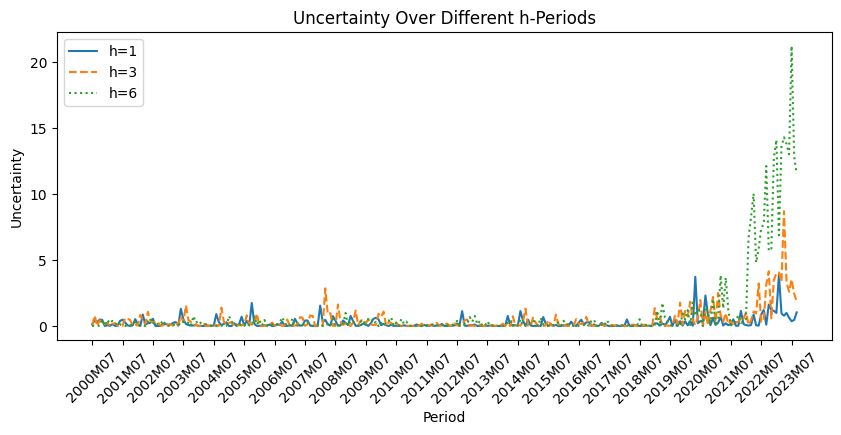

In [415]:
# Plot 'avg_uncertainty'
plt.figure(figsize=(10, 4))
plt.plot(uncertainties_1['period'], uncertainties_1['uncertainty'], label='h=1', linestyle='-')
plt.plot(uncertainties_3['period'], uncertainties_3['uncertainty'], label='h=3', linestyle='--')
plt.plot(uncertainties_6['period'], uncertainties_6['uncertainty'], label='h=6', linestyle=':')


plt.title('Uncertainty Over Different h-Periods')
plt.xlabel('Period')
plt.ylabel('Uncertainty')
plt.legend()

# Set x-axis ticks at intervals of 12 periods and rotate x-labels
plt.xticks(uncertainties_1['period'][::12], rotation=45)
plt.show()



In [416]:
# Save to csv
uncertainties_1.to_csv('../data/processed/uncertainty_index.csv', index=False, encoding='utf')